In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

On considére dans ce cas l'équation de Burgers avec diffusion non linéaire suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \epsilon \frac{\partial}{\partial x}\left(\left| \frac{\partial u}{\partial x} \right| \frac{\partial u}{\partial x} \right) \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [71]:
" **** Solutions initiales proposées **** "

@njit
def u0(x):
    #Chock & Détente
    if x <= 1 / 4:
        return ul
    if 1 / 4 < x < 3 / 4:
        return um
    else:
        return ur

@njit
def u0_Gauss(x):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin(100 * (L - l) * np.pi * x / (L - l))


" **** Le flux exact **** "
@njit
def F(u):
    return (u**2) / 2

" **** Les flx numériques proposés **** "
@njit
def Rusanov(ug, ud, dx, dt):
    # Flux numérique Rusanov
    lamda = max(abs(ug), abs(ud))
    return 0.5 * (F(ug) + F(ud)) - lamda * (ud - ug)

@njit
def Rusanov2(ug, ud, dx, dt):
    # Deuxième version du flux numérique Rusanov
    lamda = max(abs(ug), abs(ud))
    return 0.5 * (F(ug) + F(ud) - lamda * (ud - ug))

@njit
def Roe(ug, ud, dx, dt):
    # Flux numérique Roe
    return 0.5 * ((F(ug) + F(ud)) - (ug + ud) / 2 * (ud - ug))

@njit
def LF(ug, ud, dx, dt):
    # Flux numérique Lax-Friedrichs
    return 0.5 * ((F(ug) + F(ud)) - (dx / dt) * (ud - ug))

@njit
def LFM(ug, ud, dx, dt):
    # Flux numérique Lax-Friedrichs modifié
    return 0.5 * ((F(ug) + F(ud)) - 0.5 * (dx / dt) * (ud - ug))

@njit
def LW(ug, ud, dx, dt):
    # Flux numérique Lax-Wendroff
    A = 0.5 * (ud + ug)
    return 0.5 * (F(ug) + F(ud) - (dt / dx) * A * (F(ud) - F(ug)))

@njit
def departure(dt, alpha, X, u):
    aux = 1.0
    eps = 1e-9

    x0 = 0.5 * (X[:-1] + X[1:])
    xmp = x0
    kit = 0

    while aux > eps:
        x1 = xmp - dt * alpha * np.max(u)
        aux = np.max(np.abs(x1 - x0))

        x0 = x1
        kit += 1

    return x0, kit

@njit
def FvcFlux(N, X, alpha, dt, u):
    F = np.zeros(N - 1)
    up = np.zeros(N - 1)
    
    # Characteristics foot
    x0, _ = departure(dt, alpha, X, u)

    # Interpolation procedure
    ui = np.interp(x0, X, u)

    # Predictor stage
    for i in range(N - 1):
        up[i] = ui[i]

    # Corrector stage
    for i in range(N - 1):
        F[i] = 0.5 * up[i]**2

    return F

@njit
def VFC(U0, T,  N,  alpha, dx, CFL):
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    temps = 0
    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**p)
        max_diff = np.max(absolute_differences)
        
        if epsilon != 0:
            dt1  = CFL*(dx/(2*np.max(np.abs(Un))*alpha))
            dt2  = CFL * 0.5 * dx**2 / np.abs(epsilon*max_diff)
            dt  = min(dt1,dt2)
        else:
            if epsilon == 0:
                dt  = CFL * dx / np.max(np.abs(Un))
                
        temps += min(dt,T-dt)
        for i in range(1,N-1):
            X1 = X[i-1:i+2]
            u  = Un[i-1:i+2]
            F  = FvcFlux(3, X1, alpha, dt, u)
            Fg = F[0]
            Fd = F[1]
            FDd = (np.abs((Un[i+1]-Un[i])/dx))**p * (Un[i+1]-Un[i])/dx
            FDg = (np.abs((Un[i]-Un[i-1])/dx))**p * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * dt/dx * (FDd-FDg)
            
        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]
        Un = Unp1.copy()
    return Un


@njit
def Solver(U0, epsilon, T, l, L, N, CFL, scheme,p):

    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LW
    elif scheme == 4:
        flux = LFM
    
        
    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**p)
        max_diff = np.max(absolute_differences)
        
        if epsilon != 0:
            dt  = CFL /(np.max(np.abs(Un))/dx + 2 * np.abs(epsilon*max_diff)/(dx**2))
        else:
            if epsilon == 0:
                dt  = CFL * dx / np.max(np.abs(Un))
            
        
        dt = min(dt, T - temps)
        temps += dt
        
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],dx,dt)
            Fg = flux(Un[i-1],Un[i],dx,dt)
            FDd = (np.abs((Un[i+1]-Un[i])/dx))**p * (Un[i+1]-Un[i])/dx
            FDg = (np.abs((Un[i]-Un[i-1])/dx))**p * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * dt/dx * (FDd-FDg)
            
            
        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un[:] = Unp1[:]
        

    return Un


##############################################################################################################
ul       =   0.2
um       =   0.8
ur       =   0.4
T        =   1/8
l        =   0
L        =   2
epsilon  =   0.01
N        =   201
CFL      =   0.5
alpha    =   0.25
X        =   np.linspace(l,L,N)
U0       =   np.array([u0(x) for x in X]) 
p        =   1

dx = (L - l) / (N - 1)




" **** Calcul des solutions approchées **** "

f = {}

fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LW",3):1,("LFM",4):1 }

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  Solver  (U0, epsilon, T, l, L, N, CFL, i[1], p)   
    
U_VFC = VFC( U0, T,  N,  alpha, dx, CFL)

f['VFC'] = U_VFC

/tmp/ipykernel_56554/2865063776.py:167: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):


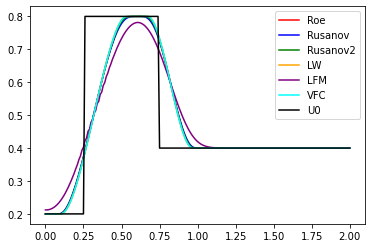

In [72]:
PLOT = {"Roe":1, "Rusanov":1, "Rusanov2":1, "LW":1, "LFM":1, "VFC":1}

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    
plt.plot(X, U0, '-k',  label='U0')

#plt.xlim([0.3, 0.5])  
#plt.ylim([6, 12])  

plt.legend()
plt.pause(0.1)


In [59]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm


{'Roe': 6.538717891423916,
 'Rusanov': 6.518639221308248,
 'Rusanov2': 6.538497475897616,
 'LW': 6.558223890909472,
 'LFM': 6.461695021737443,
 'VFC': nan}